**Install Dependencies**

In [ ]:
# Install required packages for Colab/Jupyter
!pip install pandas numpy scikit-learn tensorflow econml matplotlib seaborn fredapi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 13.1 MB/s eta 0:00:00


Import Libraries and Set Seed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from econml.dml import LinearDML
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

# Set random seed for reproducibility
np.random.seed(42)

Load and Preprocess Macroeconomic Data

In [ ]:
# Load and preprocess macroeconomic data
def load_macro_data():
    # Load datasets (upload these to Colab or ensure paths are correct in Jupyter)
    gdp = pd.read_csv('/content/drive/MyDrive/Colab/hybride model data/GDPC1.csv', parse_dates=['observation_date']).rename(columns={'GDPC1': 'GDP'})
    cpi = pd.read_csv('/content/drive/MyDrive/Colab/hybride model data/CPIAUCSL.csv', parse_dates=['observation_date']).rename(columns={'CPIAUCSL': 'CPI'})
    unemp = pd.read_csv('/content/drive/MyDrive/Colab/hybride model data/UNRATE.csv', parse_dates=['observation_date']).rename(columns={'UNRATE': 'Unemployment'})

    # Load interest rate data from FRED (replace with your FRED API key)
    fred = Fred(api_key='5333568c9d8463b553a83a85ec771c83')
    interest_rate = fred.get_series('FEDFUNDS').to_frame(name='interest_rate').reset_index().rename(columns={'index': 'observation_date'})
    interest_rate['observation_date'] = pd.to_datetime(interest_rate['observation_date'])

    # Resample to monthly frequency and align
    gdp.set_index('observation_date', inplace=True)
    gdp = gdp.resample('MS').ffill()
    cpi.set_index('observation_date', inplace=True)
    unemp.set_index('observation_date', inplace=True)
    interest_rate.set_index('observation_date', inplace=True)

    df = gdp.join(cpi, how='inner').join(unemp, how='inner').join(interest_rate, how='inner')
    df.dropna(inplace=True)

    print("Macroeconomic data shape:", df.shape)
    print(df.head())
    return df

macro_df = load_macro_data()

Macroeconomic data shape: (847, 4)
                       GDP    CPI  Unemployment  interest_rate
observation_date                                              
1954-07-01        2880.482  26.86           5.8           0.80
1954-08-01        2880.482  26.85           6.0           1.22
1954-09-01        2880.482  26.81           6.1           1.07
1954-10-01        2936.852  26.72           5.7           0.85
1954-11-01        2936.852  26.78           5.3           0.83


Load and Preprocess Firm Data

In [ ]:
# Load and preprocess firm data
def load_firm_data():
    firm_data = pd.read_csv('/content/drive/MyDrive/Colab/hybride model data/bds2022.csv')
    firm_data['survival_rate'] = 1 - (firm_data['firmdeath_firms'] / firm_data['firms'])
    firm_data = firm_data[['year', 'survival_rate']]

    print("Firm data shape:", firm_data.shape)
    print(firm_data.head())
    return firm_data

firm_data = load_firm_data()

Firm data shape: (45, 2)
   year  survival_rate
0  1978       0.908297
1  1979       0.910581
2  1980       0.901265
3  1981       0.899917
4  1982       0.891412


**Create Sequences for LSTM**

In [ ]:
# Create sequences for LSTM
def create_sequences(data, window=12):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# **Cell 6: Train LSTM Model**

In [ ]:
# Train LSTM model
def train_lstm(df):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = create_sequences(scaled, window=12)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        LSTM(32),
        Dense(df.shape[1])
    ])

    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

    print("LSTM training completed.")
    return model, scaler, X_test, y_test

lstm_model, scaler, X_test, y_test = train_lstm(macro_df)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0399 - val_loss: 0.0116
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/ste

**Cell 7: Forecast Macroeconomic Variables**

In [ ]:
# Forecast future macroeconomic variables
def forecast_macro(model, scaler, last_sequence, steps=12):
    forecast = []
    current_sequence = last_sequence.copy()

    for _ in range(steps):
        current_sequence_reshaped = current_sequence.reshape((1, current_sequence.shape[0], current_sequence.shape[1]))
        next_pred = model.predict(current_sequence_reshaped, verbose=0)
        forecast.append(next_pred[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_pred[0]

    forecast = np.array(forecast)
    pad = np.zeros((forecast.shape[0], scaler.feature_names_in_.shape[0] - forecast.shape[1]))
    forecast_full = np.hstack((forecast, pad))
    forecast_inv = scaler.inverse_transform(forecast_full)[:, :scaler.feature_names_in_.shape[0]]

    print("Forecast shape:", forecast_inv.shape)
    return forecast_inv

last_sequence = scaler.transform(macro_df.iloc[-12:]).reshape(1, 12, macro_df.shape[1])[0]
forecast = forecast_macro(lstm_model, scaler, last_sequence, steps=12)

Forecast shape: (12, 4)


# Cell 8: Simulate VAT Policy Scenarios

In [ ]:
# Simulate VAT policy scenarios
def simulate_vat_scenarios(forecast, vat_changes=[-0.05, 0, 0.05]):
    scenarios = []
    for change in vat_changes:
        scenario = forecast.copy()
        # Assume VAT impacts CPI directly (simplified assumption)
        scenario[:, 1] = scenario[:, 1] * (1 + change)
        scenarios.append(scenario)
    return scenarios

scenarios = simulate_vat_scenarios(forecast)
print("VAT scenarios generated for changes:", [-0.05, 0, 0.05])

VAT scenarios generated for changes: [-0.05, 0, 0.05]


# Cell 9: Prepare Data for DML

In [ ]:
# Prepare data for DML
def prepare_dml_data(macro_df, firm_data):
    macro_annual = macro_df.resample('YE').mean().reset_index()
    macro_annual['year'] = macro_annual['observation_date'].dt.year
    macro_annual = macro_annual.drop(columns=['observation_date'])

    merged_data = pd.merge(firm_data, macro_annual, on='year', how='inner')
    merged_data['gdp_growth'] = merged_data['GDP'].pct_change() * 100
    merged_data['inflation'] = merged_data['CPI'].pct_change(12) * 100
    merged_data['employment_rate'] = 100 - merged_data['Unemployment']
    merged_data.dropna(inplace=True)

    print("Merged data shape:", merged_data.shape)
    print(merged_data.head())
    return merged_data

merged_data = prepare_dml_data(macro_df, firm_data)

Merged data shape: (33, 9)
    year  survival_rate          GDP         CPI  Unemployment  interest_rate  \
12  1990       0.902392  10055.12850  130.658333      5.616667       8.099167   
13  1991       0.897152  10044.23750  136.166667      6.850000       5.687500   
14  1992       0.905893  10398.04625  140.308333      7.491667       3.521667   
15  1993       0.914062  10684.17875  144.475000      6.908333       3.022500   
16  1994       0.912825  11114.64625  148.225000      6.100000       4.201667   

    gdp_growth   inflation  employment_rate  
12    1.885958  100.268233        94.383333  
13   -0.108313   87.600459        93.150000  
14    3.522505   70.311552        92.508333  
15    2.751791   58.880132        93.091667  
16    4.029018   53.547997        93.900000  


# Cell 10: Estimate Causal Effects with DML

In [ ]:
# Estimate causal effects with DML
def estimate_causal_effects(data, treatment_col='interest_rate', outcome_col='survival_rate'):
    model = LinearDML(
        model_y=GradientBoostingRegressor(),
        model_t=GradientBoostingRegressor(),
        discrete_treatment=False
    )

    model.fit(
        Y=data[outcome_col],
        T=data[treatment_col],
        X=data[['gdp_growth', 'inflation', 'employment_rate']]
    )

    ate = model.ate(X=data[['gdp_growth', 'inflation', 'employment_rate']])
    ate_ci = model.ate_interval(X=data[['gdp_growth', 'inflation', 'employment_rate']])
    print(f"ATE of {treatment_col} on {outcome_col}: {ate:.3f} (CI: {ate_ci})")

    return model

dml_model = estimate_causal_effects(merged_data)

ATE of interest_rate on survival_rate: 0.000 (CI: (np.float64(-0.0015002774742236486), np.float64(0.0021059079241476965)))


# Cell 11: Visualize Results

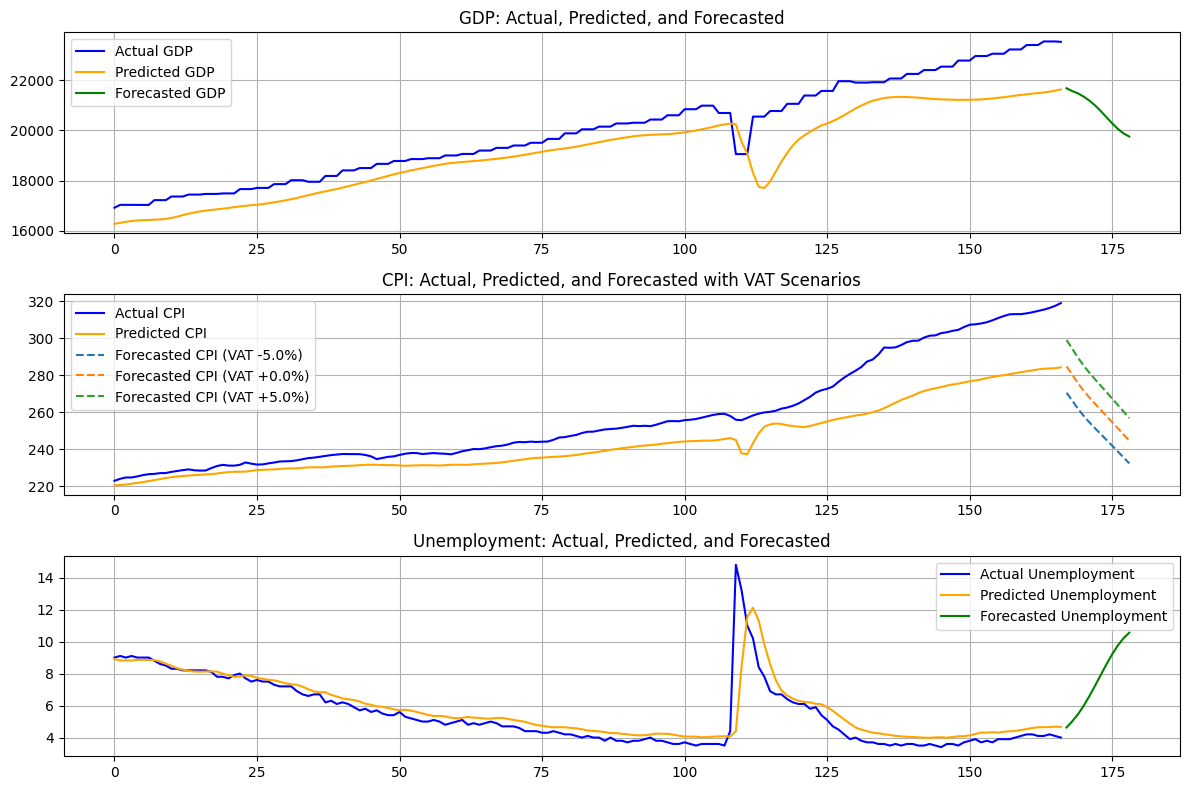

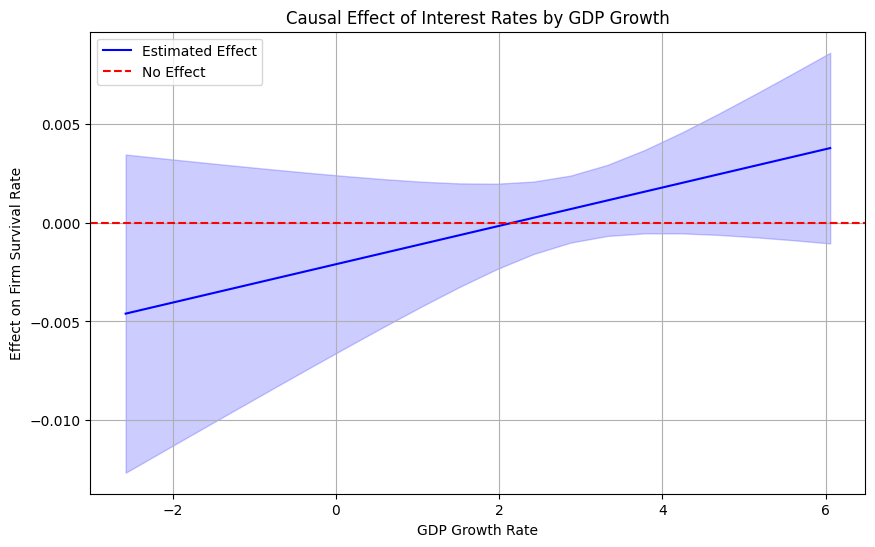

GDP MSE: 1099042.8545137243
CPI MSE: 273.5856567709937
Unemployment MSE: 1.0813995067527686


In [ ]:
# Visualize results
def visualize_results(y_test_inv, y_pred_inv, merged_data, model, forecast, scenarios):
    # Plot LSTM forecasts
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(y_test_inv[:, 0], label='Actual GDP', color='blue')
    plt.plot(y_pred_inv[:, 0], label='Predicted GDP', color='orange')
    plt.plot(range(len(y_test_inv), len(y_test_inv) + len(forecast)), forecast[:, 0], label='Forecasted GDP', color='green')
    plt.title('GDP: Actual, Predicted, and Forecasted')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(y_test_inv[:, 1], label='Actual CPI', color='blue')
    plt.plot(y_pred_inv[:, 1], label='Predicted CPI', color='orange')
    for i, scenario in enumerate(scenarios):
        plt.plot(range(len(y_test_inv), len(y_test_inv) + len(scenario)), scenario[:, 1],
                 label=f'Forecasted CPI (VAT {[-0.05, 0, 0.05][i]*100:+.1f}%)', linestyle='--')
    plt.title('CPI: Actual, Predicted, and Forecasted with VAT Scenarios')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(y_test_inv[:, 2], label='Actual Unemployment', color='blue')
    plt.plot(y_pred_inv[:, 2], label='Predicted Unemployment', color='orange')
    plt.plot(range(len(y_test_inv), len(y_test_inv) + len(forecast)), forecast[:, 2], label='Forecasted Unemployment', color='green')
    plt.title('Unemployment: Actual, Predicted, and Forecasted')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('lstm_forecasts.png', dpi=300)
    plt.show()

    # Plot DML causal effects
    gdp_grid = np.linspace(merged_data['gdp_growth'].min(), merged_data['gdp_growth'].max(), 20)
    X_test = np.zeros((len(gdp_grid), 3))
    X_test[:, 0] = gdp_grid
    X_test[:, 1] = merged_data['inflation'].mean()
    X_test[:, 2] = merged_data['employment_rate'].mean()

    effects = model.effect(X=X_test)
    lower, upper = model.effect_interval(X=X_test)

    plt.figure(figsize=(10, 6))
    plt.plot(gdp_grid, effects, 'b-', label='Estimated Effect')
    plt.fill_between(gdp_grid, lower, upper, alpha=0.2, color='b')
    plt.axhline(y=0, color='r', linestyle='--', label='No Effect')
    plt.xlabel('GDP Growth Rate')
    plt.ylabel('Effect on Firm Survival Rate')
    plt.title('Causal Effect of Interest Rates by GDP Growth')
    plt.legend()
    plt.grid(True)
    plt.savefig('causal_effects.png', dpi=300)
    plt.show()

# Generate predictions for visualization
y_pred = lstm_model.predict(X_test, verbose=0)
pad = np.zeros((y_pred.shape[0], macro_df.shape[1] - y_pred.shape[1]))
y_pred_full = np.hstack((y_pred, pad))
y_test_full = np.hstack((y_test, pad))
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, :macro_df.shape[1]]
y_test_inv = scaler.inverse_transform(y_test_full)[:, :macro_df.shape[1]]

# Visualize
visualize_results(y_test_inv, y_pred_inv, merged_data, dml_model, forecast, scenarios)

# Print MSE for LSTM predictions
print("GDP MSE:", mean_squared_error(y_test_inv[:, 0], y_pred_inv[:, 0]))
print("CPI MSE:", mean_squared_error(y_test_inv[:, 1], y_pred_inv[:, 1]))
print("Unemployment MSE:", mean_squared_error(y_test_inv[:, 2], y_pred_inv[:, 2]))